# Task 2 : Surface Defect Classification with Xception model

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import glob


# Data Preparation and Loading for Model Training

**Gathering TFRecord Files for Training and Testing Sets**

In [3]:
train_tfrecord_files = glob.glob('/kaggle/input/tfrecords-dataset/train_tfrecords/*.tfrecord')
test_tfrecord_files = glob.glob('/kaggle/input/tfrecords-dataset/test_tfrecords/*.tfrecord')
# Verify that files are found
print(f"Found {len(train_tfrecord_files)} training TFRecord files")
print(f"Found {len(test_tfrecord_files)} testing TFRecord files")

Found 1440 training TFRecord files
Found 360 testing TFRecord files


**TFRecord Parsing and Dataset Preparation functions definition for Xception Model**

In [5]:
def parse_tfrecord_example(example_proto):
    """
    Parses a single TFRecord example into a formatted example.

    This function takes a serialized TFRecord example and applies a defined schema to parse
    it into a TensorFlow example with a specific structure. It is designed to extract
    the features 'image/encodedrawdata' and 'image/object/class/label' from the input example.

    Parameters:
    - example_proto: A serialized Example to parse.

    Returns:
    - example: A dictionary containing the parsed data of the features defined in the schema.
    """

    # Define the feature description for parsing, which matches the structure of the TFRecord file
    image_feature_description = {
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
    }
    # Parse the input serialized TFRecord example according to the defined feature description
    example = tf.io.parse_single_example(example_proto, image_feature_description)
    return example




In [6]:
def load_dataset(tfrecord_files, batch_size=32):
    """
    Load and preprocess a dataset from TFRecord files.

    This function reads TFRecord files, parses the contained examples using the `parse_tfrecord_example` function,
    decodes and resizes the images, and batches the dataset.

    Parameters:
    - tfrecord_files: A list of filepaths to the TFRecord files to load.
    - batch_size: An integer representing the number of items to include in a batch.

    Returns:
    - A `tf.data.Dataset` object representing the loaded and preprocessed dataset ready for training or evaluation.
    """

    # Create a dataset from the list of TFRecord files
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)
    # Parse each serialized TFRecord example in the dataset
    parsed_dataset = raw_dataset.map(parse_tfrecord_example)
    
    def decode_image_and_resize(feature):
        # Decode the image data from 'image/encodedrawdata' into a tensor and resize it
        image = tf.image.decode_jpeg(feature['image/encodedrawdata'], channels=3)
        image = tf.image.resize(image, [299, 299])  # Resize to the expected input size for the model
        # Extract the label associated with the image
        label = feature['image/object/class/label']
        return image, label
    
    # Apply the decoding and resizing function to each parsed example and batch the dataset
    return parsed_dataset.map(decode_image_and_resize).batch(batch_size)


* I Chose a batch size of 32 for a balance between efficient GPU memory usage and good model generalization, a common practice in deep learning for image classification.
* I Resized images to 299x299 to match Xception model's expected input size, optimizing for the network's architecture and performance.
* Used channels=3 to convert grayscale images to RGB format, ensuring compatibility with Xception's color image expectations.


In [9]:
def inspect_label_distribution(tfrecord_files):
    """
 This function inspects and prints the distribution of labels within a dataset stored in TFRecord format.
 It iterates over each TFRecord, parses it to extract the label for each example, 
 then calculates and displays the count of each unique label present in the dataset.
  """

    labels = []
    for raw_record in tf.data.TFRecordDataset(tfrecord_files):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        labels.append(example.features.feature['image/object/class/label'].int64_list.value[0])
    print(f"Label distribution: {dict((label, labels.count(label)) for label in set(labels))}")


**Step 1 : Dividing data into: train, validation, and test sets**

In [7]:
#1. Shuffles the list of training TFRecord files randomly to ensure varied training batches.
np.random.shuffle(train_tfrecord_files)
#2. Determines an 80-20 split for training and validation data
split_size = int(0.8 * len(train_tfrecord_files))
#3. Split the TFRecord files
train_tfrecord_files_split = train_tfrecord_files[:split_size]
val_tfrecord_files_split = train_tfrecord_files[split_size:]

In [8]:
train_dataset = load_dataset(train_tfrecord_files_split)  # Load and preprocess the training dataset
val_dataset = load_dataset(val_tfrecord_files_split)      # Load and preprocess Validation data
test_dataset = load_dataset(test_tfrecord_files)          # Load and preprocess Test data 

**Check Label distribution**

In [10]:
inspect_label_distribution(train_tfrecord_files)
inspect_label_distribution(test_tfrecord_files)

Label distribution: {0: 240, 1: 240, 2: 240, 3: 240, 4: 240, 5: 240}
Label distribution: {0: 60, 1: 60, 2: 60, 3: 60, 4: 60, 5: 60}


=>The label distribution indicates that the data is balanced, with an equal number of samples for each class

# Deep Learning Pipeline: Model Definition, Benchmarking  and Evaluation

**Model Definition**


In [17]:
# Function to create the model based on optimizer name and learning rate
def create_model(optimizer_name, learning_rate):
    """
Constructs a model based on the Xception architecture for image classification, tailored with customizable optimizer and learning rate.

This function initializes an Xception model preloaded with ImageNet weights, tailored for feature extraction by freezing its convolutional base. 
It adds a custom classifier on top of the base model consisting of batch normalization, global average pooling, a dense layer, and dropout for regularization.
The final output layer's activation and dimensions are set for classification tasks. 
The optimizer can be chosen among Adam, Nadam, or SGD, with a specified learning rate.

Parameters:

optimizer_name: A string specifying the optimizer ('Adam', 'Nadam', 'SGD').
learning_rate: A float specifying the learning rate for the optimizer.

Returns:

A compiled Keras model ready for training.
"""
    
    base_model = tf.keras.applications.Xception(input_shape=(image_height, image_width, n_color_channels),
                                                include_top=False,
                                                weights="imagenet")
    base_model.trainable = False  # Freeze the base model
    
    inputs = tf.keras.Input(shape=(image_height, image_width, n_color_channels))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(8, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(n_classes, activation='relu')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
        
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model




**Optimizers and Learning Rates Selection**
* Adam, Nadam, and SGD were chosen due to their effectiveness in various scenarios. Adam and Nadam are ideal for complex problems with sparse gradients, while SGD offers a simple, transparent approach. 
* I Chose momentum=0.9 to accelerate SGD's convergence and navigate smoother past local minima, enhancing the classification performance with Xception.
* The learning rates (0.001, 0.0001, 0.00001) range from fast to conservative, allowing for a balance between quick convergence and precision, tailored to the task's needs.

In [15]:
param_grid = {
    'optimizer': ['Adam', 'Nadam', 'SGD'],
    'learning_rate': [0.001, 0.0001, 0.00001]  
}


**Early Stopping Strategy**
* Early stopping prevents overfitting by halting training when validation loss doesn't improve, with a patience of 15 epochs. 
* I chose patience of 15 epochs since This balance allows enough time for learning while conserving resources and avoiding overfitting, optimizing model performance and efficiency.

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

**Model Training, Evaluation, and Optimization Cycle :**

**Initial Setup:** Set initial conditions with best_accuracy to track the highest accuracy, best_model to store the model with the highest accuracy, best_params for its parameters, and results list for storing the outcome of each training iteration for analysis.

**Model Training:** Iterate over combinations of optimizers and learning rates defined in param_grid. For each combination, a model is created and trained using the training dataset, with validation performed on the validation dataset.

**Evaluation:** After training, each model is evaluated on the test dataset to obtain test accuracy and loss.

**Result Storage:** The optimizer, learning rate, test loss, and test accuracy for each training iteration are stored in the results list for later analysis.

**Best Model Selection:** If a model achieves a higher test accuracy than the current best_accuracy, its accuracy, parameters, and model instance are updated as the new best.

**Model Saving:** The best-performing model, based on test accuracy, is saved for future use or deployment.

**Final Output:** Outputs include the test accuracy and loss for each combination tested, and the best model's optimizer and learning rate when training concludes.

In [18]:
image_height = 299
image_width = 299
n_color_channels = 3
n_classes = 6

best_accuracy = 0
best_model = None
best_params = None
results = []  # List to store all results for plotting

for optimizer_name in param_grid['optimizer']:
    for lr in param_grid['learning_rate']:
        print(f"Training with {optimizer_name} optimizer at learning rate {lr}")
        model = create_model(optimizer_name, lr)
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=40, callbacks=[early_stopping], shuffle=True)
        
        test_loss, test_acc = model.evaluate(test_dataset)
        print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")
        
        # Store results for all runs
        results.append({
            'optimizer': optimizer_name,
            'learning_rate': lr,
            'test_loss': test_loss,
            'test_accuracy': test_acc
        })
        
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model = model
            best_history = history.history
            best_params = {'optimizer': optimizer_name, 'learning_rate': lr}

# Save the best model
if best_model is not None:
    tf.saved_model.save(best_model, 'my_model')
    print(f"Best model saved with optimizer: {best_params['optimizer']} and learning rate: {best_params['learning_rate']}")
else:
    print("No model was trained.")



Training with Adam optimizer at learning rate 0.001
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/40
      1/Unknown 21s 21s/step - accuracy: 0.2188 - loss: 1.8027

I0000 00:00:1710029085.128088     179 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710029085.170383     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     36/Unknown 25s 116ms/step - accuracy: 0.3401 - loss: 1.5891

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1710029092.481312     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.3422 - loss: 1.5850 - val_accuracy: 0.4653 - val_loss: 1.3769
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.5583 - loss: 1.0993 - val_accuracy: 0.7326 - val_loss: 0.7989
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.6591 - loss: 0.9151 - val_accuracy: 0.8785 - val_loss: 0.5536
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.6975 - loss: 0.8254 - val_accuracy: 0.9167 - val_loss: 0.4267
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.6905 - loss: 0.7732 - val_accuracy: 0.9340 - val_loss: 0.3540
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.7100 - loss: 0.7507 - val_accuracy: 0.9271 - val_loss: 0.3166
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.7071 - loss: 0.7137 - val_accuracy: 0.9340 - val_loss: 0.2930
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.7314 - loss: 0.6896 - val_accuracy: 0.9340 - va

W0000 00:00:1710029333.276631     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     36/Unknown 13s 114ms/step - accuracy: 0.1840 - loss: 1.8010

W0000 00:00:1710029340.192602     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.1852 - loss: 1.8004 - val_accuracy: 0.2847 - val_loss: 1.7284
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.3000 - loss: 1.7310 - val_accuracy: 0.4340 - val_loss: 1.6506
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.3834 - loss: 1.6630 - val_accuracy: 0.5833 - val_loss: 1.5587
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.4267 - loss: 1.5954 - val_accuracy: 0.6250 - val_loss: 1.4754
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.4166 - loss: 1.5352 - val_accuracy: 0.6354 - val_loss: 1.4004
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.4448 - loss: 1.4800 - val_accuracy: 0.6389 - val_loss: 1.3368
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.4273 - loss: 1.4406 - val_accuracy: 0.6458 - val_loss: 1.2864
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.4431 - loss: 1.3986 - val_accuracy: 0.6493 

W0000 00:00:1710029470.618776     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     36/Unknown 13s 114ms/step - accuracy: 0.1441 - loss: 1.8103

W0000 00:00:1710029477.460615     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.1446 - loss: 1.8103 - val_accuracy: 0.2361 - val_loss: 1.7970
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.1554 - loss: 1.8036 - val_accuracy: 0.2361 - val_loss: 1.7867
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.1906 - loss: 1.7918 - val_accuracy: 0.2604 - val_loss: 1.7788
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.2099 - loss: 1.7770 - val_accuracy: 0.2778 - val_loss: 1.7680
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.2330 - loss: 1.7706 - val_accuracy: 0.3160 - val_loss: 1.7545
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.2637 - loss: 1.7531 - val_accuracy: 0.3681 - val_loss: 1.7379
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.2934 - loss: 1.7399 - val_accuracy: 0.4028 - val_loss: 1.7200
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.2751 - loss: 1.7233 - val_accuracy: 0.4201 - va

W0000 00:00:1710029582.679776     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     36/Unknown 13s 114ms/step - accuracy: 0.4256 - loss: 1.5253

W0000 00:00:1710029589.558715     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.4270 - loss: 1.5206 - val_accuracy: 0.6875 - val_loss: 0.8634
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.5302 - loss: 1.0844 - val_accuracy: 0.8021 - val_loss: 0.6563
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.5665 - loss: 0.9604 - val_accuracy: 0.9097 - val_loss: 0.5022
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.6238 - loss: 0.8494 - val_accuracy: 0.9236 - val_loss: 0.4130
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.6693 - loss: 0.7866 - val_accuracy: 0.9444 - val_loss: 0.3345
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.6741 - loss: 0.7948 - val_accuracy: 0.9479 - val_loss: 0.2988
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.6997 - loss: 0.7258 - val_accuracy: 0.9514 - val_loss: 0.2733
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.7165 - loss: 0.6666 - val_accuracy: 0.9514 - v

W0000 00:00:1710029690.526493     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     36/Unknown 12s 114ms/step - accuracy: 0.2133 - loss: 1.7794

W0000 00:00:1710029697.344400     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.2144 - loss: 1.7787 - val_accuracy: 0.3472 - val_loss: 1.7109
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.3643 - loss: 1.6656 - val_accuracy: 0.4896 - val_loss: 1.5449
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.3785 - loss: 1.5744 - val_accuracy: 0.5278 - val_loss: 1.4126
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.4203 - loss: 1.4829 - val_accuracy: 0.5590 - val_loss: 1.3157
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.4466 - loss: 1.3876 - val_accuracy: 0.5799 - val_loss: 1.2339
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.4395 - loss: 1.3354 - val_accuracy: 0.6181 - val_loss: 1.1666
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.4430 - loss: 1.3277 - val_accuracy: 0.6736 - val_loss: 1.1158
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.4908 - loss: 1.2767 - val_accuracy: 0.6840 - va

W0000 00:00:1710029794.030845     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     36/Unknown 13s 114ms/step - accuracy: 0.0945 - loss: 1.8211

W0000 00:00:1710029800.846281     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.0945 - loss: 1.8209 - val_accuracy: 0.1632 - val_loss: 1.8234
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.1215 - loss: 1.8021 - val_accuracy: 0.1771 - val_loss: 1.7751
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.1435 - loss: 1.7830 - val_accuracy: 0.2188 - val_loss: 1.7527
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.1530 - loss: 1.7649 - val_accuracy: 0.2500 - val_loss: 1.7354
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.1826 - loss: 1.7585 - val_accuracy: 0.2778 - val_loss: 1.7190
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.1882 - loss: 1.7471 - val_accuracy: 0.3090 - val_loss: 1.7017
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.2291 - loss: 1.7307 - val_accuracy: 0.3507 - val_loss: 1.6841
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.2196 - loss: 1.7106 - val_accuracy: 0.3819 - v

W0000 00:00:1710029903.687032     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     36/Unknown 12s 114ms/step - accuracy: 0.2451 - loss: 1.7819

W0000 00:00:1710029910.554493     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.2463 - loss: 1.7799 - val_accuracy: 0.3681 - val_loss: 1.4618
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.4305 - loss: 1.4915 - val_accuracy: 0.5035 - val_loss: 1.2322
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.5257 - loss: 1.3399 - val_accuracy: 0.6111 - val_loss: 1.0930
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.5425 - loss: 1.2600 - val_accuracy: 0.6875 - val_loss: 0.9915
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.5827 - loss: 1.1959 - val_accuracy: 0.7153 - val_loss: 0.9248
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.6051 - loss: 1.1098 - val_accuracy: 0.7431 - val_loss: 0.8632
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.6129 - loss: 1.0616 - val_accuracy: 0.7778 - val_loss: 0.8062
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.6306 - loss: 1.0210 - val_accuracy: 0.7812 - va

W0000 00:00:1710030003.068291     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     36/Unknown 12s 114ms/step - accuracy: 0.2563 - loss: 1.7707

W0000 00:00:1710030009.895326     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.2564 - loss: 1.7707 - val_accuracy: 0.3611 - val_loss: 1.7069
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.2471 - loss: 1.7673 - val_accuracy: 0.3611 - val_loss: 1.6992
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.2752 - loss: 1.7312 - val_accuracy: 0.4201 - val_loss: 1.6842
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.3154 - loss: 1.7150 - val_accuracy: 0.4757 - val_loss: 1.6625
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.3388 - loss: 1.6896 - val_accuracy: 0.4965 - val_loss: 1.6365
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.3832 - loss: 1.6729 - val_accuracy: 0.5243 - val_loss: 1.6089
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.4052 - loss: 1.6455 - val_accuracy: 0.5243 - val_loss: 1.5795
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.4530 - loss: 1.5948 - val_accuracy: 0.5660 - va

W0000 00:00:1710030111.209728     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


     36/Unknown 12s 114ms/step - accuracy: 0.1373 - loss: 1.8217

W0000 00:00:1710030118.066292     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.1372 - loss: 1.8215 - val_accuracy: 0.0312 - val_loss: 1.8752
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.1272 - loss: 1.8068 - val_accuracy: 0.0694 - val_loss: 1.8355
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.1680 - loss: 1.8060 - val_accuracy: 0.0938 - val_loss: 1.8156
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.1482 - loss: 1.8048 - val_accuracy: 0.1181 - val_loss: 1.8037
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.1555 - loss: 1.7956 - val_accuracy: 0.1597 - val_loss: 1.7939
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.1869 - loss: 1.7882 - val_accuracy: 0.1840 - val_loss: 1.7855
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.1786 - loss: 1.7863 - val_accuracy: 0.2153 - val_loss: 1.7782
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.2059 - loss: 1.7765 - val_accuracy: 0.2257 - v

**Visualize test accuracy by learning rate and optimizer using Seaborn bar plots**

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


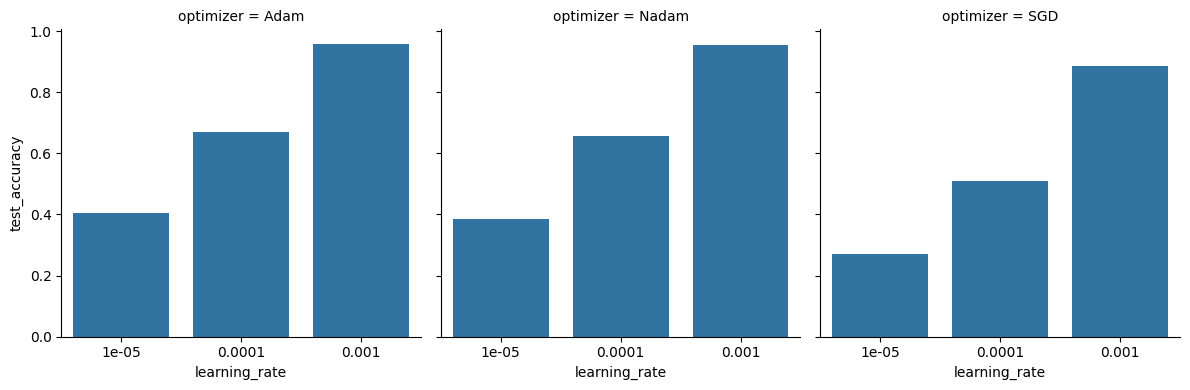

In [19]:
results_df = pd.DataFrame(results)

g = sns.FacetGrid(results_df, col="optimizer", height=4, aspect=1)
g.map(sns.barplot, "learning_rate", "test_accuracy")




* => Adam performs best at a learning rate of 0.001(Test accuracy: **0.96**, Test loss: **0.14**), while Nadam peaks at nearly the same rate(Test accuracy: **0.95**, Test loss:**0.17**), indicating a faster learning process could be beneficial for these optimizers.
* The underperformance of SGD compared to Adam and Nadam could be due to several reasons. SGD typically requires more iterations and careful tuning of the learning rate since it doesn't have the adaptive learning rate mechanism that Adam and Nadam have. 
* Overall, Adam and Nadam outperform SGD across the tested learning rates.

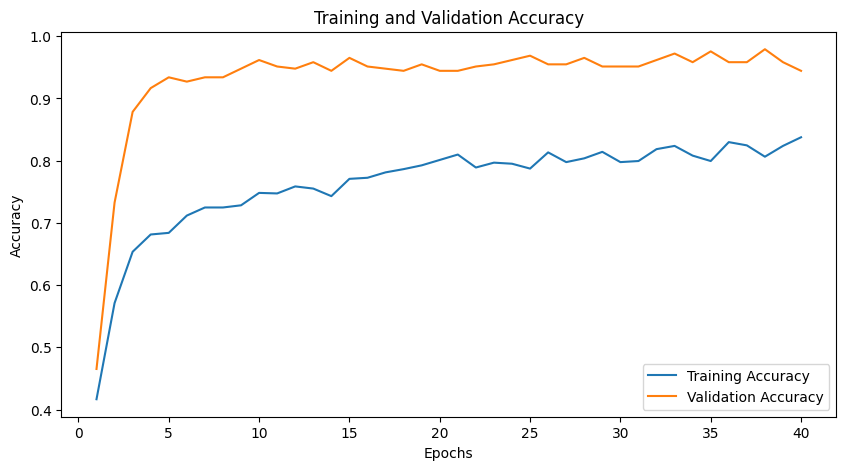

In [20]:

train_accuracy = best_history['accuracy']
val_accuracy = best_history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')


plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

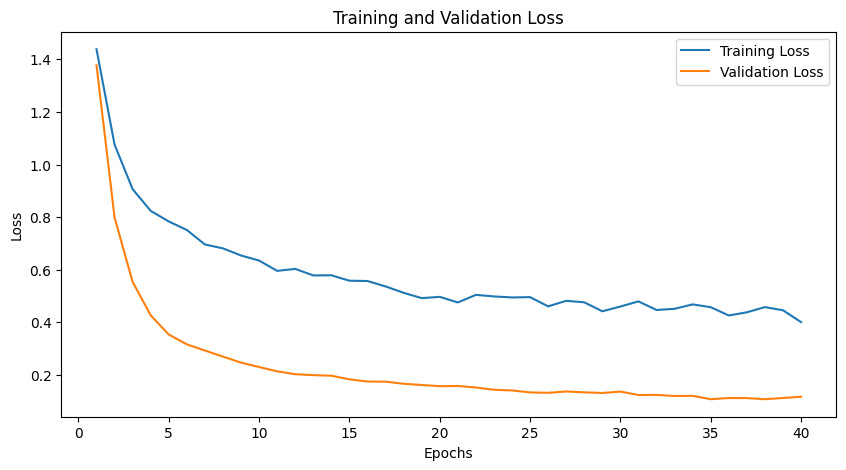

In [21]:
# Extract loss history
train_loss =best_history['loss']
val_loss = best_history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


* The graphs shows an uncommon case where the validation accuracy surpasses the training accuracy and validation loss is lower than training loss. This could indicate that the model, with its current complexity including only **8 units** and a high **dropout rate of 40%**, may be too simplistic or regularized to capture the underlying patterns in the training data. However, it still generalizes well to the validation set and test set.
* Since I was constrained with specific hyperparameter values in this task , **I made the adjustment in another notebook (Enhanced_Model_Complexity.ipynb)**. By increasing the model's complexity there, specifically to **256 units in the dense layer**, I addressed the issue. This change enabled the model to learn more intricate features from the training data, leading to improved generalization, which closed the gap between training and validation loss and accuracy ultimately leading to improved model performance

In [22]:
test_images, test_labels = next(iter(test_dataset.unbatch().batch(360)))  
predictions = best_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels.numpy()

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Calculate and display the classification report including the F1 score
report = classification_report(true_classes, predicted_classes)
print(report)

 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step

W0000 00:00:1710030798.000050     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        60
           1       0.95      0.93      0.94        60
           2       0.98      0.97      0.97        60
           3       0.92      0.93      0.93        60
           4       1.00      1.00      1.00        60
           5       0.95      0.95      0.95        60

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



* The report shows that all classes have high precision, recall, and F1-scores, indicating a strong performance across the board. 
* Class 4 has perfect precision and recall, leading to an F1-score of 1.00. 
* Overall accuracy is 0.96, and both the macro average and weighted average of precision, recall, and F1-score are 0.96, confirming the model's excellent predictive ability with balanced support for each class.

In [23]:
loss, accuracy = best_model.evaluate(test_dataset)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9554 - loss: 0.1573
Test loss: 0.1409, Test accuracy: 0.9583


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


* The best model achieved a **test accuracy** of approximately **95.58%** and a **test loss** of **0.1409** when evaluated on the test dataset. 
* the model demonstrates a high accuracy and low loss on the test data, indicating effective learning and generalization.

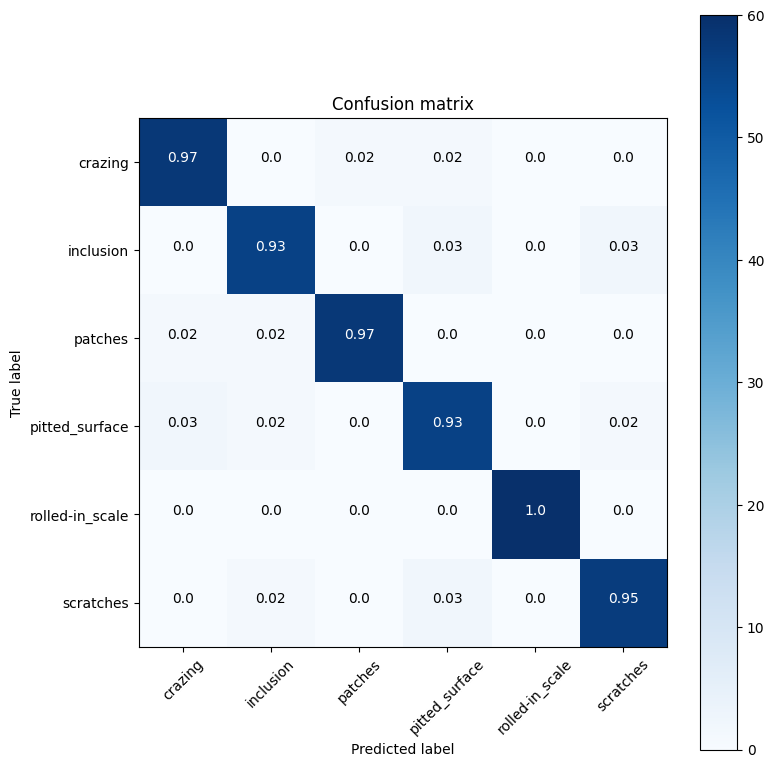

In [24]:

cm = confusion_matrix(true_classes, predicted_classes)

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    #  white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches'] 
plot_confusion_matrix(cm, class_names)
plt.show()


# Inference on TFRecord Test Samples


**Load the saved model**

In [25]:
loaded_model = tf.saved_model.load('my_model')


In [27]:
class_names = {
    0: 'crazing',
    1: 'inclusion',
    2: 'patches',
    3: 'pitted_surface',
    4: 'rolled-in_scale',
    5: 'scratches'
}



In [29]:
def parse_tfrecord_example_for_visualization(example_proto):
    """
Prepares and parses TFRecord examples for model inference and visualization.

This function decodes images stored in serialized TFRecord examples for both feeding them into the model and displaying the original images. 
It decodes the image twice: once for input to the model, resizing it to the model's expected input size, 
and once in its original form for visualization purposes.

Parameters:

example_proto: The serialized TFRecord example to parse.
Returns:

image_for_model: The decoded and resized image tensor for model inference.
image_for_visualization: The decoded image tensor in its original size for visualization.
"""
    image_feature_description = {
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    # Decode the image data for model input
    image_for_model = tf.image.decode_jpeg(example['image/encodedrawdata'], channels=3)
    image_for_model = tf.image.resize(image_for_model, [299, 299])
    
    #  decode the original image for visualization
    image_for_visualization = tf.image.decode_jpeg(example['image/encodedrawdata'], channels=3)
    
    return image_for_model, image_for_visualization



In [42]:
def load_dataset_for_inference_and_visualization(tfrecord_files, batch_size=1):
    """
Prepares a dataset for model inference and visualization from TFRecord files.

This function loads TFRecord files into a TensorFlow dataset, 
Each TFRecord is processed to yield a pair of image tensors: 
one for input into the model, and one in its original size for visualization.
The dataset is batched, with a default batch size of 1, suitable for inference on individual images.

Parameters:

tfrecord_files: A list of paths to the TFRecord files.
batch_size: The number of items to include in each batch (default is 1 for individual inference).

Returns:

A batched tf.data.Dataset with pairs of tensors for model input and visualization.
"""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = raw_dataset.map(parse_tfrecord_example_for_visualization)
    return dataset.batch(batch_size)

In [ ]:
def softmax(x):
    """
Calculates the softmax of a set of scores in x.

The softmax function converts a vector of numbers into a vector of probabilities,
where the probabilities of each value are proportional to the exponential of the original values. 

Parameters:

x: An array of scores to be converted into probabilities.

Returns:

An array of the same shape as x representing normalized softmax probabilities.
"""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [44]:
tfrecord_file_for_inference = ['/kaggle/input/tfrecords-samples-for-inference/rolled-in_scale_rolled-in_scale_256.jpg.tfrecord']
test_dataset = load_dataset_for_inference_and_visualization(tfrecord_file_for_inference, batch_size=1)


* The dataset 'tfrecords-samples-for-inference' contains 6 TFRecord samples designated for model inference.

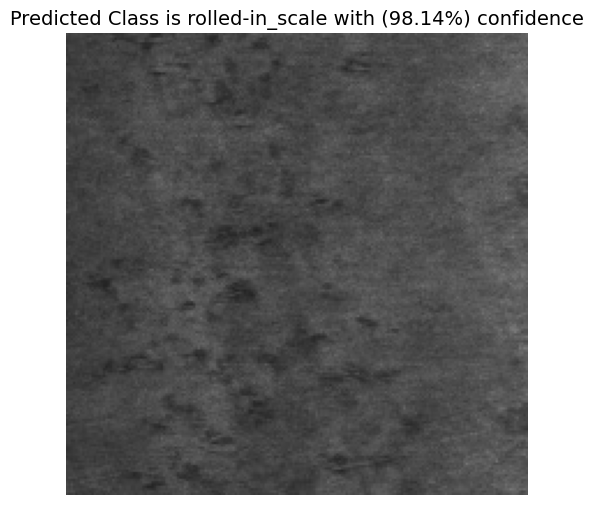

In [46]:
for image_batch, image_visualization_batch in test_dataset:
    predictions = loaded_model.signatures['serving_default'](inputs=tf.constant(image_batch, dtype=tf.float32))
    predicted_scores = predictions['output_0'].numpy()  # 'output_0' is the model output name
    probabilities = softmax(predicted_scores)  # Compute softmax to get probabilities
    predicted_labels = np.argmax(predicted_scores, axis=1)
    max_probabilities = np.max(probabilities, axis=1) * 100  # Convert to percentage

    # Translate numeric labels into meaningful class names and add prediction confidence
    predicted_class_names_with_confidence = [
        f"Predicted Class is {class_names[label]} with ({confidence:.2f}%) confidence" for label, confidence in zip(predicted_labels, max_probabilities)
    ]

    # Visualization
    for image_visualization, predicted_class_name_with_confidence in zip(image_visualization_batch, predicted_class_names_with_confidence):
        plt.figure(figsize=(6, 6))
        plt.imshow(image_visualization.numpy().astype("uint8"))
        plt.title(predicted_class_name_with_confidence, fontsize=14)  # Display class with confidence (expected :rolled-in_scale) 
        plt.axis('off')
        plt.show()


In [39]:
tfrecord_files_for_inference = ['/kaggle/input/tfrecords-samples-for-inference/rolled-in_scale_rolled-in_scale_256.jpg.tfrecord',
                               '/kaggle/input/tfrecords-samples-for-inference/pitted_surface_pitted_surface_277.jpg.tfrecord',
                               '/kaggle/input/tfrecords-samples-for-inference/scratches_scratches_270.jpg.tfrecord',
                               '/kaggle/input/tfrecords-samples-for-inference/patches_patches_285.jpg.tfrecord'
                              ]

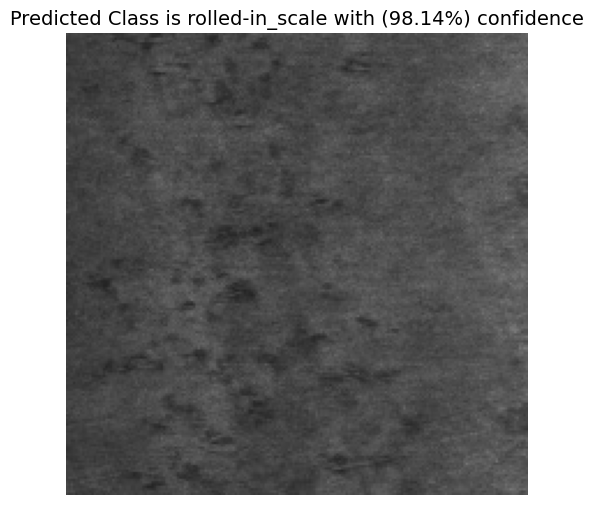

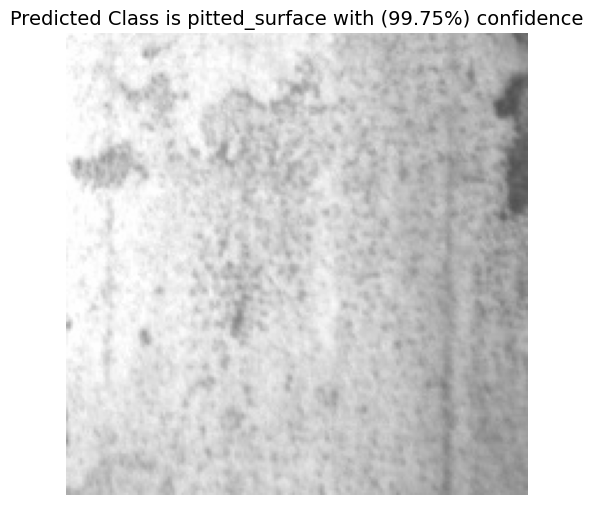

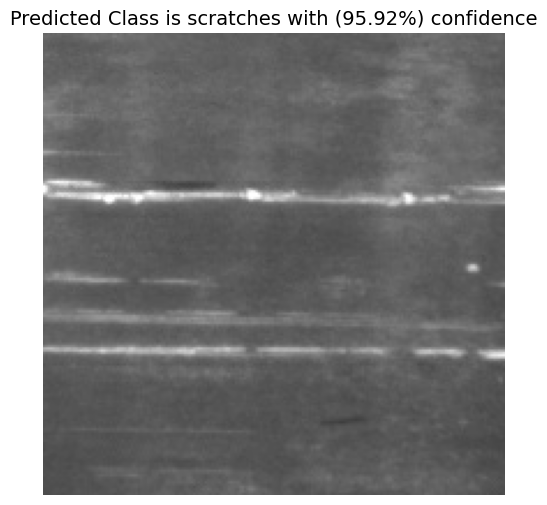

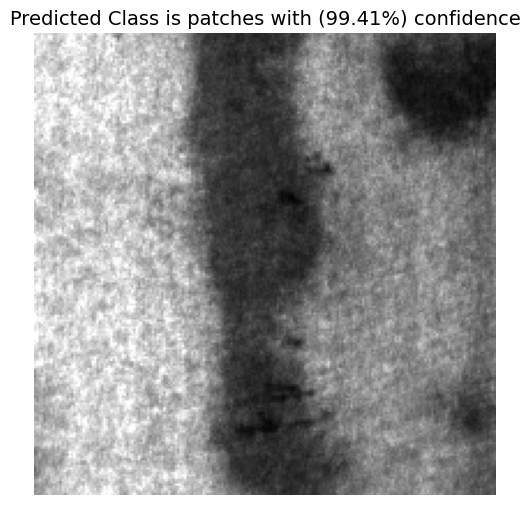

In [40]:
test_dataset = load_dataset_for_inference_and_visualization(tfrecord_files_for_inference, batch_size=1)


for image_batch, image_visualization_batch in test_dataset:
    predictions = loaded_model.signatures['serving_default'](inputs=tf.constant(image_batch, dtype=tf.float32))
    predicted_scores = predictions['output_0'].numpy()  # 'output_0' is the model output name
    probabilities = softmax(predicted_scores)  # Compute softmax to get probabilities
    predicted_labels = np.argmax(predicted_scores, axis=1)
    max_probabilities = np.max(probabilities, axis=1) * 100  # Convert to percentage

    # Translate numeric labels into meaningful class names and add prediction confidence
    predicted_class_names_with_confidence = [
        f"Predicted Class is {class_names[label]} with ({confidence:.2f}%) confidence" for label, confidence in zip(predicted_labels, max_probabilities)
    ]

    # Visualization
    for image_visualization, predicted_class_name_with_confidence in zip(image_visualization_batch, predicted_class_names_with_confidence):
        plt.figure(figsize=(6, 6))
        plt.imshow(image_visualization.numpy().astype("uint8"))
        plt.title(predicted_class_name_with_confidence, fontsize=14)  # Display class name with confidence
        plt.axis('off')
        plt.show()

* The model accurately predicted all classes, demonstrating its strong performance on new, unseen data.